# Classification for 8 classes (with all 4 features)
`fake euphoria` vs `fake goodgirl` vs `fake ysly` vs `fake theone`

`og_euphoria` vs `og_goodgirl` vs  `og ysly` vs `og_theone`

In [1]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

from matplotlib import pyplot as plt 

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay, classification_report

In [2]:
dataset = np.load('../perfumes-dataset.npz', allow_pickle=True)['data'].tolist()
dataset = [d for d in dataset if 'sauvage' not in d['name']] # exclude 'sauvage' as we dont have og to compare

In [3]:
signals = [d['data'] for d in dataset]

In [4]:
signals_array = np.array(signals)

print('Signals shape:', signals_array.shape)

Signals shape: (16, 8, 4, 10, 101)


In [5]:
signals_array = np.transpose(signals_array, (0, 2, 1, 3, 4)) # perf, feature, channel, cycle_step, signal

## Normalize data along sensor dimension 

In [6]:
perftype_splitted = []

for perf in signals_array:
    sensor_splitted = []
    for sensor in perf:
        cycle_splitted = []
        for cycle in sensor:
            channel_normalized = []
            for channel in cycle:
                mean_val = channel.mean()
                std_val = channel.std()
                normalized_val = (channel - mean_val) / std_val
                channel_normalized.append(normalized_val)
            cycle_splitted.append(channel_normalized)
        sensor_splitted.append(cycle_splitted)
    perftype_splitted.append(sensor_splitted)

singals_normalized = np.array(perftype_splitted)


In [7]:
# concatenate 
signals = []
for perf in singals_normalized:
    reshaped_resistancy = perf.reshape((4, 80, 101))
    signals.append(reshaped_resistancy)

signals = np.array(signals)

In [8]:
signals.shape

(16, 4, 80, 101)

In [9]:
labels = [d['name'] for d in dataset]
X = []
y = []
for res, lab in zip(signals, labels):
    res = np.transpose(res, (1, 0, 2))
    X.append(res)
    y.append([lab]*80)

X = np.array(X).reshape((16*80, 4, 101))
y = np.array(y).reshape((16*80))


In [10]:
X.shape

(1280, 4, 101)

In [11]:
y_ = [_.split('_')[0:2] for _ in y]
y_ = [x[0] + '_' + x[1] for x in y_]
y = np.array(y_)

In [12]:
oh = OneHotEncoder(sparse_output=True)
oh = oh.fit(y.reshape(-1, 1))


y = oh.transform(y.reshape(-1, 1))
y = y.toarray()

In [13]:
X.shape, y.shape

((1280, 4, 101), (1280, 8))

In [14]:
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), self.y[idx]

In [15]:
np.random.seed(2023)
permutation_idx = np.random.randint(low = 0, high = len(X), size = len(X)) 

X = X[permutation_idx]
y = y[permutation_idx]

In [16]:
X = torch.tensor(X).to(torch.float32)
y = torch.tensor(y, dtype = torch.float16)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2024)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=2024)

In [17]:
print('Train dataset shape;', X_train.shape)
print('Val dataset shape;', X_val.shape)
print('Test dataset shape;', X_test.shape)


Train dataset shape; torch.Size([896, 4, 101])
Val dataset shape; torch.Size([192, 4, 101])
Test dataset shape; torch.Size([192, 4, 101])


In [18]:
noised_signals = []
noised_labels = []
orig_x = []
for x, y in zip(X_train, y_train):
    p = np.random.randint(0, 100, 1)
    if p % 2 == 0:
        x_noised = []
        for feature in x:
            noise = np.random.normal(loc = 0, scale = x.std()/8, size = channel.shape[0])
            feature_noised = feature + noise
            x_noised.append(feature_noised)
        x_noised = np.array(x_noised)
        noised_signals.append(x_noised)
        noised_labels.append(y)
        orig_x.append(x)

noised_signals = np.array(noised_signals)
noised_labels = np.array(noised_labels)

In [19]:
noised_signals.shape

(448, 4, 101)

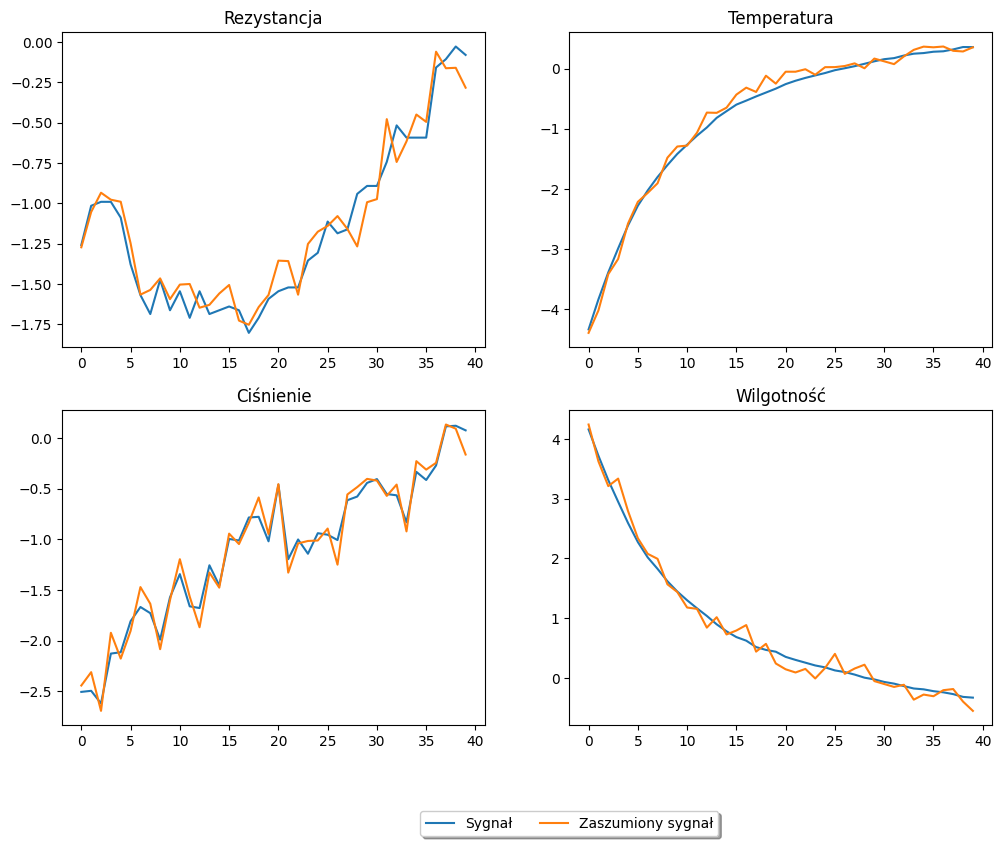

In [20]:
np.random.seed(20322)
idx = np.random.randint(0, len(noised_signals), size = 1)

x_noised = noised_signals[idx].squeeze()
x_orig = np.array(orig_x[idx[0]])

import seaborn as sns
# sns.set_style('ticks')
fig, axes = plt.subplots(nrows= 2, ncols = 2, figsize = (12, 9))

axes = axes.flatten()

# for x, xn in zip(x_orig, x_noised):
#     # print(x.shape)
FEATURES = ['Rezystancja', 'Temperatura', 'Ciśnienie', 'Wilgotność']
for i, (x, xn) in enumerate(zip(x_orig, x_noised)):
    # print(x.shape)
    axes[i].plot(x[:40], label = 'Sygnał')
    axes[i].plot(xn[:40], label = 'Zaszumiony sygnał')
    axes[i].set_title(FEATURES[i])

plt.legend(loc='upper center', bbox_to_anchor=(0, -0.25), fancybox=True, shadow=True, ncol=2)


# # plot noised and original signal on canvas
# sns.set_style('ticks')
# plt.figure(figsize=(12, 9))

# plt.plot(x.flatten()[:40], label = 'Sygnał')
# plt.plot(x_noised.flatten()[:40], label = 'Zaszumiony sygnał')

# plt.xlabel('t')
# plt.ylabel('Znormalizowana rezystancja')

# plt.legend(loc = 'best')


In [21]:
print('Noised samples:', noised_signals.shape[0])

Noised samples: 448


In [22]:
X_train = torch.row_stack((X_train, torch.tensor(noised_signals))).to(torch.float32)
y_train = torch.row_stack((y_train, torch.tensor(noised_labels)))


In [23]:
print('New train shape:', X_train.shape)

New train shape: torch.Size([1344, 4, 101])


In [24]:
xxxx = torch.rand((64, 101, 4))

In [25]:
torch.transpose(xxxx, 1, 2).shape

torch.Size([64, 4, 101])

In [26]:
X_train.shape

torch.Size([1344, 4, 101])

In [27]:
X_train = torch.transpose(X_train, 1, 2)
X_val = torch.transpose(X_val, 1, 2)
X_test = torch.transpose(X_test, 1, 2)

In [28]:
X_train.shape, X_val.shape, X_test.shape

(torch.Size([1344, 101, 4]),
 torch.Size([192, 101, 4]),
 torch.Size([192, 101, 4]))

In [76]:
class PerfumeClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=4, hidden_size=16, batch_first=True)
        # self.lstm1.flatten_parameters()
        self.flat = nn.Flatten()
        self.drop = nn.Dropout(0.4)
        self.dense1 = nn.Linear(16*101, 64)
        self.relu1 = nn.ReLU()

        
        self.out = nn.Linear(64, 8)

    def forward(self, x):
        # outputs = x
        outputs, _ = self.lstm1(x)
        outputs = self.flat(outputs)
        outputs = self.drop(outputs)

        outputs = self.relu1(self.dense1(outputs))

        outputs = self.out(outputs)
        return outputs

In [77]:
model = PerfumeClassifier().to('cuda')

xx = torch.rand((64, 101, 4)).to('cuda')

model(xx).shape

torch.Size([64, 8])

In [78]:
BATCH_SIZE = 32


train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TimeSeriesDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TimeSeriesDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [79]:
model = PerfumeClassifier().to('cuda')
for d in train_loader:
    xx, yy = d
    xx = torch.tensor(xx)
    o = model(xx.to('cuda'))

/tmp/ipykernel_60885/75059746.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xx = torch.tensor(xx)


In [80]:
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model = model.train()
    losses = []
    accs = []
    for i, batch in enumerate(data_loader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()


        y_truth = torch.where(y != 0)[1]
        y_pred = torch.max(outputs, 1)[1]


        total_correct = (y_truth == y_pred).sum().item()
        total_samples = y.size(0)
        
        accuracy = total_correct / total_samples
        
        losses.append(loss.item())
        accs.append(accuracy)


    return np.mean(losses), np.mean(accuracy)



def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()

    losses = []
    accs = []
    for i, batch in enumerate(data_loader):
        X, y = batch
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = loss_fn(outputs, y)
    
        y_truth = torch.where(y != 0)[1]
        y_pred = torch.max(outputs, 1)[1]

        total_correct = (y_truth == y_pred).sum().item()
        total_samples = y.size(0)
        
        accuracy = total_correct / total_samples
        

        losses.append(loss.item())
        accs.append(accuracy)

    return np.mean(losses), np.mean(accs)


In [81]:
EPOCHS = 1000
LR = 1e-3
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'
model = PerfumeClassifier()
model = model.to(DEVICE)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma = 0.9)

loss_fn = nn.CrossEntropyLoss()


In [82]:
from collections import defaultdict
import copy


history = defaultdict(list)
best_val_loss = float('inf')  # Initialize with a large value
best_val_acc = None
best_model = None

counter = 0

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, DEVICE)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, DEVICE)
    scheduler.step()

    print(f"EPOCH {epoch+1}/{EPOCHS}")
    print(f"Train loss:  {train_loss} \t Train accuracy: {train_acc}")
    print(f"Val loss: {val_loss} \t Val accuracy: {val_acc}")

    if val_loss < best_val_loss:
        print('*'*10)
        print('New best!')
        print('*'*10)
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter += 1

    if counter > 100:
        print('Early stopping called!')
        print('Training finished')
        break

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)


EPOCH 1/1000
Train loss:  1.746932069460551 	 Train accuracy: 0.375
Val loss: 1.516809304555257 	 Val accuracy: 0.4427083333333333
**********
New best!
**********
EPOCH 2/1000
Train loss:  1.3789688377153306 	 Train accuracy: 0.4375
Val loss: 1.2905609409014385 	 Val accuracy: 0.5625
**********
New best!
**********
EPOCH 3/1000
Train loss:  1.150932742016656 	 Train accuracy: 0.65625
Val loss: 1.154659370581309 	 Val accuracy: 0.5364583333333334
**********
New best!
**********
EPOCH 4/1000
Train loss:  0.9822698022638049 	 Train accuracy: 0.6875
Val loss: 1.003874550263087 	 Val accuracy: 0.6614583333333334
**********
New best!
**********
EPOCH 5/1000
Train loss:  0.8961214408988044 	 Train accuracy: 0.71875
Val loss: 0.9141782720883688 	 Val accuracy: 0.7239583333333334
**********
New best!
**********
EPOCH 6/1000
Train loss:  0.7583051040059045 	 Train accuracy: 0.71875
Val loss: 0.8176046907901764 	 Val accuracy: 0.703125
**********
New best!
**********
EPOCH 7/1000
Train loss:  0.6

In [83]:
print('Best val loss:', best_val_loss)
print('Best val accuracy:', best_val_acc)


Best val loss: 0.26554543400804204
Best val accuracy: 0.9427083333333334


In [84]:
model.load_state_dict(best_model)

<All keys matched successfully>

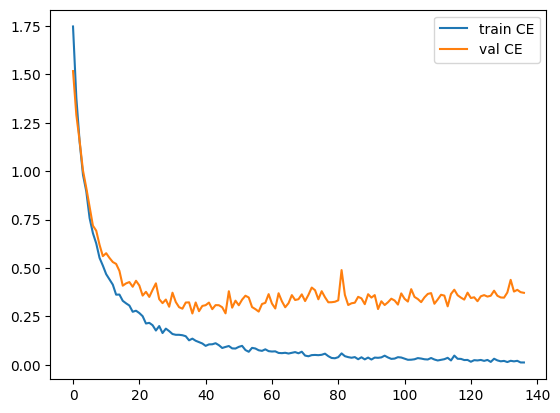

In [85]:

plt.plot(history['train_loss'], label = 'train CE')
plt.plot(history['val_loss'], label = 'val CE')

plt.legend()

In [86]:
with torch.no_grad():
    y_pred = model(X_test.to(DEVICE))
    y_pred_labels = oh.inverse_transform(y_pred.detach().cpu())

y_test_labels = oh.inverse_transform(y_test)

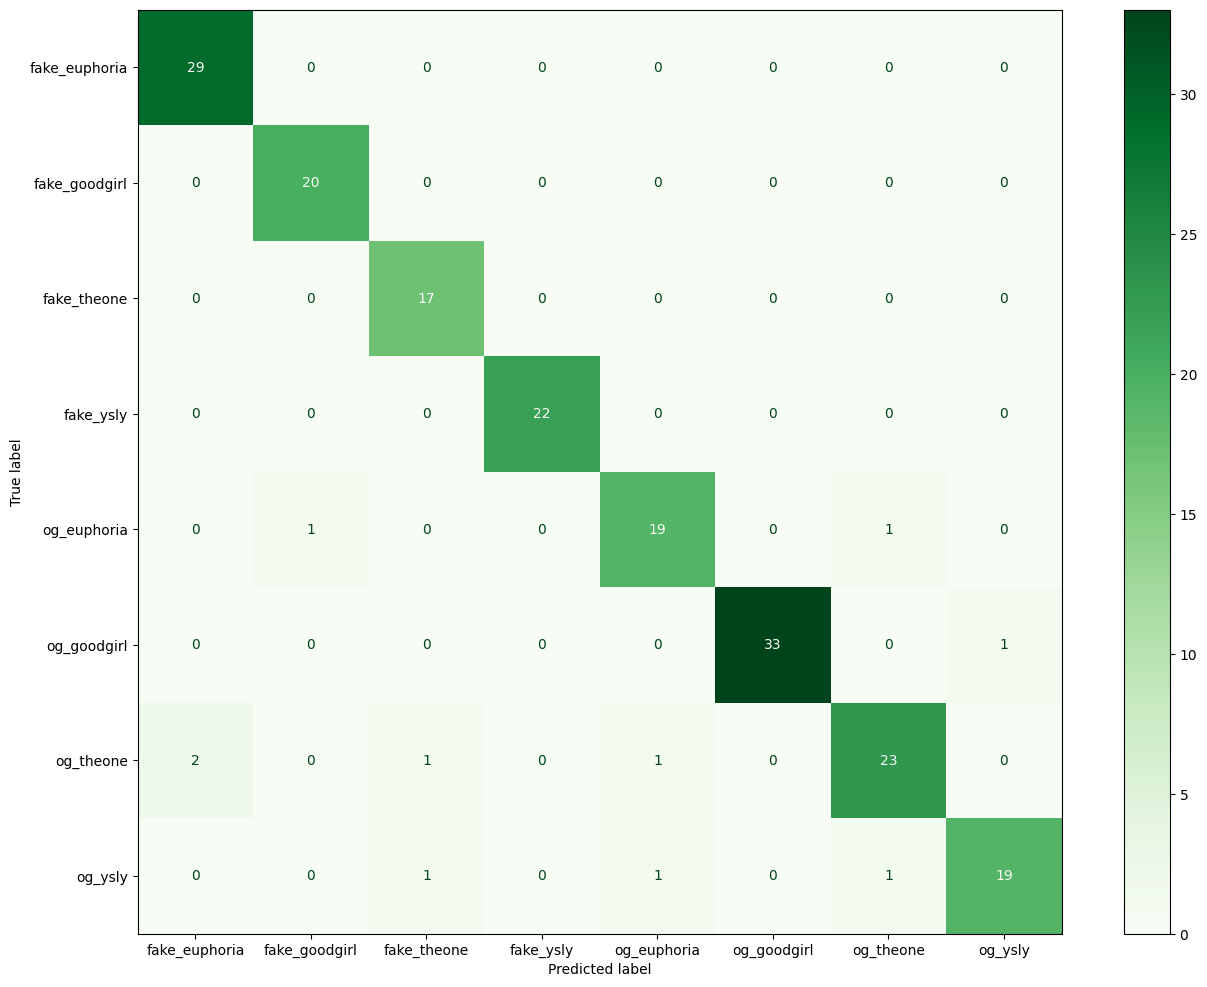

In [87]:
cm = confusion_matrix(y_true= y_test_labels, y_pred = y_pred_labels)
cm_disp = ConfusionMatrixDisplay(cm, display_labels=np.unique(y_test_labels))

fig, ax = plt.subplots(figsize=(16, 12))
cm_disp.plot(ax = ax, cmap = plt.cm.Greens)


In [88]:
print(classification_report(y_true=y_test_labels, y_pred=y_pred_labels))

               precision    recall  f1-score   support

fake_euphoria       0.94      1.00      0.97        29
fake_goodgirl       0.95      1.00      0.98        20
  fake_theone       0.89      1.00      0.94        17
    fake_ysly       1.00      1.00      1.00        22
  og_euphoria       0.90      0.90      0.90        21
  og_goodgirl       1.00      0.97      0.99        34
    og_theone       0.92      0.85      0.88        27
      og_ysly       0.95      0.86      0.90        22

     accuracy                           0.95       192
    macro avg       0.94      0.95      0.95       192
 weighted avg       0.95      0.95      0.95       192

